<a href="https://colab.research.google.com/github/Gregtom3/vossen_ecal_ai/blob/main/notebooks/tutorial_1a_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial Overview

In this section, we showcase the basic machine learning approach to resolving the false photon problem at CLAS12. We follow along with the event data collected by the `hipo2tree.C` program in [the photon AI repo](https://github.com/Gregtom3/clas12_photon_classifier). The event data was collected using a Monte Carlo event generator with simulated detector readouts in Geant4. Particles are reconstructed using the Coatjava framework.

### Imports

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools


### Data loading
Here we use `pandas` to extract the photon CSV data from the GitHub.

In [6]:
# URL to the raw CSV file
url = "https://raw.githubusercontent.com/Gregtom3/vossen_ecal_ai/main/data/photon_data_simple.csv"

# Read the CSV into a DataFrame
df = pd.read_csv(url)
columns = list(df.columns)

# Display the data frame
display(df)

# Print the length of the dataframe and number of events
print("Total number of photons =",len(df))
print("Total number of events =",len(df['event'].unique()))


# Gather model inputs and outputs
input_columns = [col for col in columns if col not in ['event','y']]
output_column = 'y'

X,y = df[input_columns],df[output_column]
event = df['event']

,event,y,gE,gTheta,gPhi,gEpcal,gm2u,gm2v,R_e,dE_e,...,R_nh_0,R_nh_1,dE_nh_0,dE_nh_1,Epcal_nh_0,Epcal_nh_1,m2u_nh_0,m2u_nh_1,m2v_nh_0,m2v_nh_1
0,2,1,0.419281,0.142198,-0.228402,0.092302,8.369318,6.233378,0.243609,-5.929922,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
1,2,0,0.381003,0.226871,0.391344,0.082348,2.468460,5.101976,0.329900,-5.968199,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
2,3,1,0.776184,0.466822,-2.159906,0.157550,7.863267,7.666647,0.561245,-5.639680,...,0.618747,0.000000,-0.628029,0.000000,0.029860,0.0,3.079798,0.0,7.635437,0.0
3,3,1,0.703621,0.424731,2.101643,0.117456,20.440538,4.125012,0.484815,-5.712243,...,0.634904,0.000000,-0.700591,0.000000,0.029860,0.0,3.079798,0.0,7.635437,0.0
4,4,1,1.066117,0.324687,1.016142,0.097080,0.375000,0.375000,0.400224,-4.978032,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,5804,0,0.551653,0.382259,0.663451,0.126606,6.050109,7.101588,0.524108,-1.888500,...,0.638292,0.648867,-1.055936,-1.551752,0.000000,0.0,0.000000,0.0,0.000000,0.0
9996,5804,0,0.519381,0.291868,1.241010,0.118255,6.370572,0.375000,0.432665,-1.920773,...,0.548478,0.557851,-1.584025,-1.088208,0.000000,0.0,0.000000,0.0,0.000000,0.0
9997,5805,1,1.171620,0.181781,-0.043148,0.077555,12.287415,0.375000,0.124504,-2.445048,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
9998,5805,0,1.140107,0.184830,-0.143282,0.076943,12.287415,13.246597,0.113860,-2.476562,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0


Total number of photons = 10000
Total number of events = 3358


## Explanation of Data

We describe the contents of the dataframe's columns. Each row describes a single photon found in an event, and the columns are that photons features which we may use during training. Many of these features are concerned with the nearest neighbors of the photon, which we elaborate more on below.

Below, $\mathrm{PARTICLE}\in[\mathrm{gamma},\mathrm{ch},\mathrm{nh}]$ where 'gamma' represents photons, 'ch' represents (any) charged hadron, and 'nh' represents (any) neutral hadron. The value $\mathrm{NUM}\in[0,1]$ for 'ch', 'nh' and $\mathrm{NUM}\in[0,1,2]$ designates the index of the nearest neighbor for that photon.

For instance, consider `dE_gamma_1`. This is the energy difference between the photon and its 2 closest neighboring photon. If there were only 2 photons in that event, then `dE_gamma_1` would be 0. All features relying on nearest neighbors are 0-padded if the number of nearest neighbors reconstructed in the event is not met.

* `event` - The event number
* `y` - [0,1] labeling the reconstructed photon as true or false
* `gE` - Reconstructed energy of the photon
* `gTheta` - Reconstructed theta of the photon
* `gPhi` - Reconstructed phi of the photon
* `gEpcal` - PCal energy deposited by the photon cluster
* `gm2u` - 2nd moment of the photon's PCal shower shape (U direction)
* `gm2v` - 2nd moment of the photon's PCal shower shape (V direction)
* `R_e`  - Angular distance between photon and nearest electron
* `dE_e` - Energy difference between photon and nearest electron
* `R_PARTICLE_NUM` - Angular difference between photon and `NUM+1` nearest `PARTICLE`
* `dE_PARTICLE_NUM`- Energy difference between photon and `NUM+1` nearest `PARTICLE`
* `Epcal_PARTICLE_NUM` - PCal energy deposited by `NUM+1` nearest `PARTICLE`
* `m2u_PARTICLE_NUM` - 2nd moment of PCal shower deposited by `NUM+1` nearest `PARTICLE` (U direction)
* `m2v_PARTICLE_NUM` - 2nd moment of PCal shower deposited by `NUM+1` nearest `PARTICLE` (V direction)


Now, lets plot some of these distributions to get a better feel of the data.

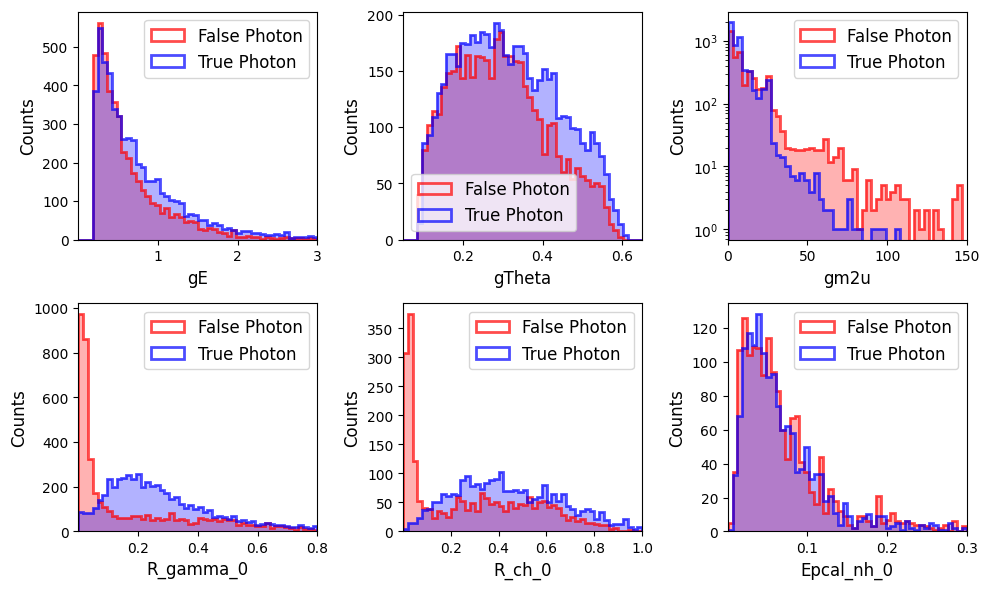

In [15]:
# Create figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Define features to plot, along with their xlimits
features = ['gE', 'gTheta', 'gm2u', 'R_gamma_0', 'R_ch_0', 'Epcal_nh_0']
xlims = [(0.001, 3), (0.05, 0.65), (0, 150), (0.001, 0.8), (0.001, 1), (0.001, 0.3)]

# Loop over all subplots
for i, ax in enumerate(axes.flat):
    feature = features[i]
    x_min = xlims[i][0]
    x_max = xlims[i][1]

    # Plot pretty histograms
    ax.hist(df[df['y'] == 0][feature], bins=50, range=(x_min,x_max), histtype='step', linewidth=2, color='red', alpha=0.7, label='False Photon')
    ax.hist(df[df['y'] == 0][feature], bins=50, range=(x_min,x_max), color='red', alpha=0.3)
    ax.hist(df[df['y'] == 1][feature], bins=50, range=(x_min,x_max), histtype='step', linewidth=2, color='blue', alpha=0.7, label='True Photon')
    ax.hist(df[df['y'] == 1][feature], bins=50, range=(x_min,x_max), color='blue', alpha=0.3)

    # Format axes
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel('Counts', fontsize=12)
    ax.set_xlim(x_min, x_max)
    if feature == 'gm2u':
      ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=10)

    # Create legend
    ax.legend(fontsize=12)

# Plot
plt.tight_layout()
plt.show()

Above, we observe several variables, such as the angular separation of a photon and its nearest neighbor, have strong discriminating power. Others, such as the PCal energy of its nearest neutron neighbor, do not.

The false photon problem is not as complex as it may seem. It would appear we could even place hard cuts on variables like `R_gamma_0` to separate True and False photons. However, we could do even better with an AI model.

## Impact on $\pi^0$ mass

In $\pi^0$ studies, we try to create $\pi^0$'s for each event by combining two photons and calculating their invariant mass. For $N$ photons in an event, this calculation creates $C(N,2)=N(N-1)/2$ $\pi^0$'s. To illustrate the impact of false photons on $\pi^0$ reconstruction, we define what "true" $\pi^0$'s are, and their three different types of background.



1.   **True $\pi^0$** - A reconstructed diphoton pair where each photon in the pair orignated from the same $\pi^0$ decay.
2.   **Bkg Type A $\pi^0$** - A reconstructed diphoton pair where each photon in the pair originated from different $\pi^0$ decays (ex: events where two $\pi^0$'s are produced).
3.   **Bkg Type B $\pi^0$** - A reconstructed diphoton pair where one photon is false, and the other originated from a $\pi^0$ decay.
4.   **Bkg Type C $\pi^0$** - A reconstructed diphoton pair where both photons are false.

In practice, our goal is to minimize Type B and Type C backgrounds. Type A background is "ok" since it corresponds to actual combinatoric backgrounds in our experiment. It is entirely plausible for two random true photons in an event to happen upon an invariant mass near the $\pi^0$ mass. By minimizing Type B and Type C, we reduce the *false* combinatoric background.


---


In the code below, we loop over each event and extract $\pi^0$'s using the `gE`, `gTheta` and `gPhi` of the photons in the event. We plot the invariant mass distribution with lines representing the different $\pi^0$ types above.



The data imported

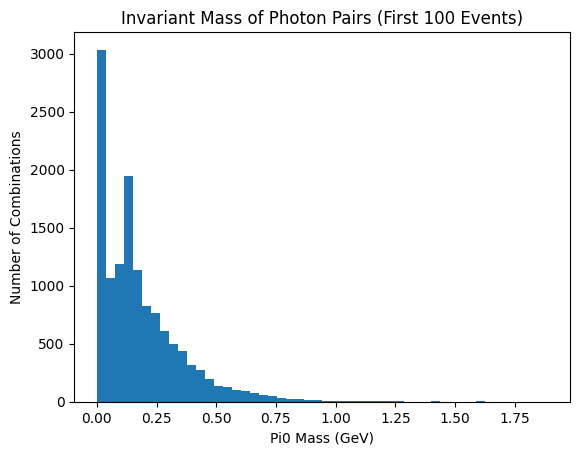

In [ ]:


def get_pi0_mass(gE, gTheta, gPhi):
    # Convert to Cartesian coordinates
    px = gE * np.sin(gTheta) * np.cos(gPhi)
    py = gE * np.sin(gTheta) * np.sin(gPhi)
    pz = gE * np.cos(gTheta)
    E = gE
    return px, py, pz, E

pi0_masses = []
events = df['event'].unique()

for event_num in events:
    event_photons = df[df['event'] == event_num]
    if len(event_photons) >= 2:
        for photon1, photon2 in itertools.combinations(event_photons.index, 2):
            gE1, gTheta1, gPhi1 = event_photons.loc[photon1, ['gE', 'gTheta', 'gPhi']]
            gE2, gTheta2, gPhi2 = event_photons.loc[photon2, ['gE', 'gTheta', 'gPhi']]

            px1, py1, pz1, E1 = get_pi0_mass(gE1, gTheta1, gPhi1)
            px2, py2, pz2, E2 = get_pi0_mass(gE2, gTheta2, gPhi2)

            total_px = px1 + px2
            total_py = py1 + py2
            total_pz = pz1 + pz2
            total_E = E1 + E2

            pi0_mass = np.sqrt(total_E**2 - (total_px**2 + total_py**2 + total_pz**2))
            pi0_masses.append(pi0_mass)

plt.hist(pi0_masses, bins=50)
plt.xlabel("Pi0 Mass (GeV)")
plt.ylabel("Number of Combinations")
plt.title("Invariant Mass of Photon Pairs")
plt.show()
